# 데이터 불러오기

In [1]:
import os
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from PIL import Image

# 사용자 정의 ImageFolder 클래스
class CustomImageFolder(ImageFolder):
    def __getitem__(self, index):
        path, _ = self.samples[index]
        sample = self.loader(path)
        if self.transform is not None:
            sample = self.transform(sample)
        if self.target_transform is not None:
            target = self.target_transform(path)  # 파일 경로를 target_transform에 전달
        return sample, target

# 라벨 지정 함수
def labeler(path):
    filename = os.path.basename(path)
    return 0 if 'pass' in filename else 1

# 이미지 변환 정의
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # 모든 이미지를 224x224 크기로 조정
    transforms.ToTensor()
])

# 훈련 데이터셋 로드
train_dataset = CustomImageFolder(r'C:\Users\amk25\D\clipped_(4)',
                                  transform=transform, target_transform=labeler)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# 테스트 데이터셋 로드
test_dataset = CustomImageFolder(r'C:\Users\amk25\D\clipped_(4)',
                                 transform=transform, target_transform=labeler)

# 검증 데이터셋으로 분할
val_size = int(0.7 * len(test_dataset))
test_size = len(test_dataset) - val_size
val_dataset, test_dataset = random_split(test_dataset, [val_size, test_size], generator=torch.Generator().manual_seed(42))
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# 훈련 모델 설정

In [2]:
# CustomCNN 모델 정의
class CustomCNN(nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 110 * 110, 128)  # 수정된 입력 크기
        self.fc2 = nn.Linear(128, 2)  # 이진 분류를 위해 출력 크기를 2로 변경

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        
#         # 현재 x의 크기를 출력하여 확인
#         print(x.size())  # 이 줄을 추가하여 x의 크기를 출력        
        
        x = x.view(-1, 64 * 110 * 110)  # 수정된 플래튼 크기
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# 모델, 손실 함수, 최적화 함수 초기화
model = CustomCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 훈련 함수 정의
def train_model(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0

    for images, labels in tqdm(train_loader, desc='Training', leave=False):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader)
    return epoch_loss

# 검증 함수 정의
def evaluate_model(model, data_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct_predictions = 0

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            _, preds = torch.max(outputs, 1)
            correct_predictions += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(data_loader)
    epoch_acc = correct_predictions.float() / len(data_loader.dataset)
    return epoch_loss, epoch_acc

# 모델 학습 및 검증

In [3]:
# 학습 및 검증
import torch.nn.functional as F
num_epochs = 5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(num_epochs):
    train_loss = train_model(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = evaluate_model(model, val_loader, criterion, device)

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}')

    # 조기 종료
    if epoch > 5:  # 조기 종료를 위한 임시 조건, 필요에 따라 조절
        break

# 모델 저장
# 모델 저장 경로 설정
save_path = r'C:\Users\amk25\D\clipped_(4)\model_weights_cnn.pth'
torch.save(model.state_dict(), save_path)

# 테스트 데이터 평가
test_loss, test_acc = evaluate_model(model, test_loader, criterion, device)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}')

Epoch 1/5, Train Loss: 1.0108, Validation Loss: 0.0503, Validation Accuracy: 1.0000


Epoch 2/5, Train Loss: 0.0051, Validation Loss: 0.0008, Validation Accuracy: 1.0000


Epoch 3/5, Train Loss: 0.0005, Validation Loss: 0.0003, Validation Accuracy: 1.0000


Epoch 4/5, Train Loss: 0.0002, Validation Loss: 0.0001, Validation Accuracy: 1.0000


Epoch 5/5, Train Loss: 0.0001, Validation Loss: 0.0001, Validation Accuracy: 1.0000
Test Loss: 0.0001, Test Accuracy: 1.0000


In [4]:
import os
import torch
from torchvision import transforms
from PIL import Image
from torchvision.models import efficientnet_v2_s
import torch.nn.functional as F

# # 사전 훈련된 EfficientNetV2 모델을 불러오고, 분류기 부분을 수정합니다.
# model = efficientnet_v2_s(pretrained=False)
# num_features = model.classifier[1].in_features
# model.classifier[1] = torch.nn.Linear(num_features, 2)  # 2개의 클래스로 분류하기 위해 변경

# 모델의 가중치를 불러옵니다. 가중치 파일이 'model_weights.pth'라고 가정합니다.
model.load_state_dict(torch.load(save_path, map_location=torch.device('cpu')))
model.eval()  # 모델을 평가 모드로 설정

# 장치 설정 - 이 예제에서는 CPU를 사용합니다.
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model.to(device)

# 이미지 변환 정의
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # 이미지 크기 조정
    transforms.ToTensor()           # 이미지를 PyTorch 텐서로 변환
])

# './test_dataset' 폴더에서 이미지 파일 목록을 가져옵니다.
test_dataset_path = r'C:\Users\amk25\D\(4)_test'
image_files = [f for f in os.listdir(test_dataset_path) if os.path.isfile(os.path.join(test_dataset_path, f)) and f.lower().endswith(('png', 'jpg', 'jpeg'))]
image_paths = [os.path.join(test_dataset_path, img_file) for img_file in image_files]

# 실제 레이블은 파일명에 'pass' 또는 'fail' 포함 여부에 따라 결정됩니다.
actual_labels = [0 if 'pass' in img_file else 1 for img_file in image_files]

# 예측 및 일치율 계산
for path, actual_label in zip(image_paths, actual_labels):
    image = Image.open(path).convert('RGB')
    image = transform(image).unsqueeze(0).to(device)
    
    with torch.no_grad():
        outputs = model(image)
        probabilities = F.softmax(outputs, dim=1)
        predicted = torch.max(probabilities, 1)[1]
        probability = probabilities[0, predicted.item()].item()  # 예측된 클래스의 확률
    
    # 일치율을 퍼센트로 변환
    similarity_percent = 100 * probability
    
    print(f'File: {os.path.basename(path)}, Actual Label: {actual_label}, Predicted Label: {predicted.item()}, Similarity: {similarity_percent:.2f}%')

File: clipped_fail_1004.png, Actual Label: 1, Predicted Label: 1, Similarity: 99.99%
File: clipped_fail_11.png, Actual Label: 1, Predicted Label: 1, Similarity: 100.00%
File: clipped_fail_352.png, Actual Label: 1, Predicted Label: 1, Similarity: 100.00%
File: clipped_fail_6.png, Actual Label: 1, Predicted Label: 1, Similarity: 100.00%
File: clipped_fail_689.png, Actual Label: 1, Predicted Label: 1, Similarity: 100.00%
File: clipped_fail_9.png, Actual Label: 1, Predicted Label: 1, Similarity: 100.00%
File: clipped_pass_1.png, Actual Label: 0, Predicted Label: 0, Similarity: 100.00%


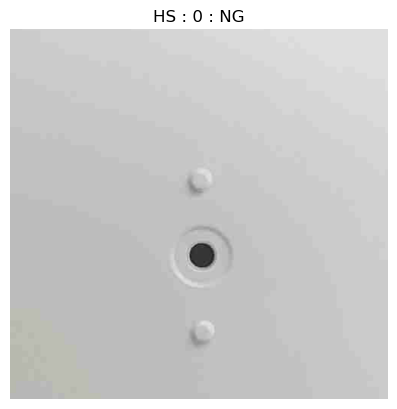

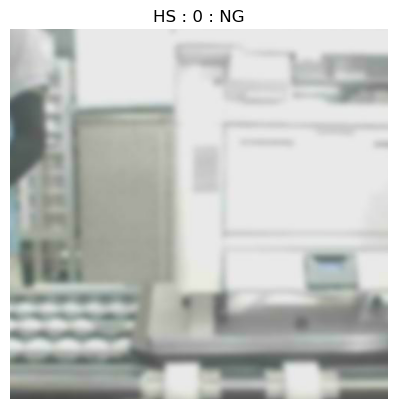

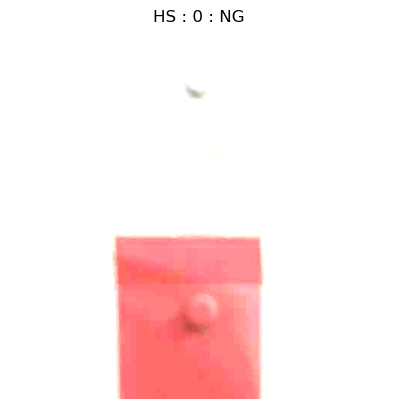

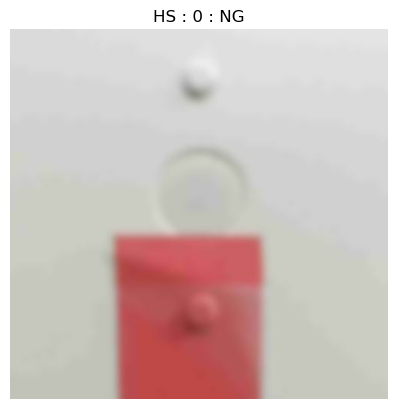

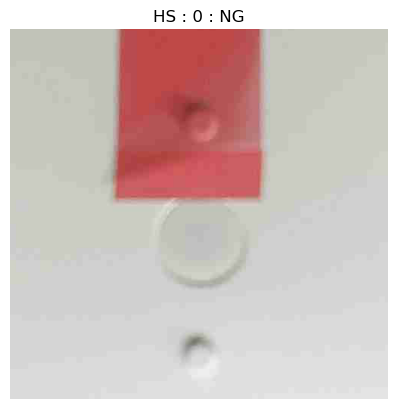

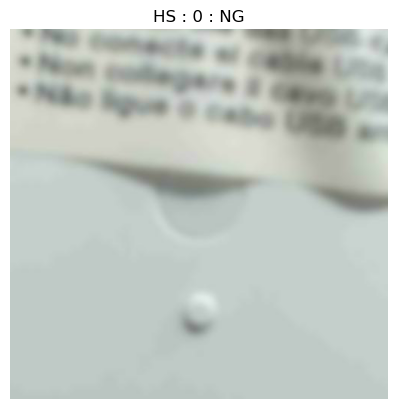

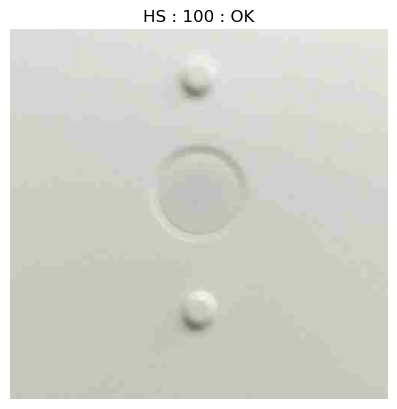

In [6]:
# 이미지 파일의 경로, 실제 레이블, 예측 레이블, 일치율을 출력하고 이미지를 띄우는 함수
import matplotlib.pyplot as plt

# 이미지 파일의 경로, 실제 레이블, 예측 레이블, 일치율을 출력하고 이미지를 띄우는 함수
def display_image_with_label(path, actual_label, predicted_label, accuracy_percent):
    image = Image.open(path)
    plt.imshow(image)
    
    # 조건에 따른 결과 표시
    if actual_label == 1 and predicted_label == 1:
        result = "NG"
    elif actual_label == predicted_label and accuracy_percent >= 90:
        result = "OK"
    else:
        result = "NG"

    plt.title(f'HS : {accuracy_percent:.0f} : {result}')
    plt.axis('off')
    plt.show()

# 예측 및 일치율 계산
for path, actual_label in zip(image_paths, actual_labels):
    image = Image.open(path).convert('RGB')
    image = transform(image).unsqueeze(0).to(device)
    
    with torch.no_grad():
        outputs = model(image)
        probabilities = F.softmax(outputs, dim=1)
        predicted = torch.max(probabilities, 1)[1]
        
        # 클래스 1에 속할 확률을 추출하고 퍼센트로 변환
        probability_class_1 = probabilities[0, 0].item()  # 레이블 1에 속할 확률
        similarity_percent = 100 * probability_class_1
    
    # 이미지와 레이블 정보를 출력하고 이미지를 띄웁니다.
    display_image_with_label(path, actual_label, predicted.item(), similarity_percent)